In [1]:
import glob 
from os import path 
from time import perf_counter as clock

In [2]:
import ppxf as ppxf_package
from ppxf.ppxf import ppxf
import ppxf.ppxf_util as util

In [3]:
from astropy.io import fits
from scipy import ndimage 
import numpy as np

import matplotlib.pyplot as plt

In [4]:
#def ppxf_example_kinematics_sauron():
ppxf_dir = '/home/nicole/.local/lib/python3.8/site-packages/ppxf' 
eso325_dir = '/home/nicole/eso325/espectros' #caminho da pasta

In [5]:
file = eso325_dir + '/36x43.fits'    #Nome do arquivo
hdu = fits.open(file)                #Abertura do arquivo #This is the top-level FITS object. When a FITS file is opened, a HDUList object is returned.
gal_lin = hdu[1].data                #Fluxo
h1 = hdu[1].header                   #Header
#print(gal_lin)

In [6]:
noise = np.sqrt(hdu[2].data) # tirando raiz da extensão STAT do arquivo FITS(variância de cada medida), calculando ruído como desvio padrão

In [7]:
lamRange1 = h1['CRVAL1'] + np.array([0., h1['CDELT1']*(h1['NAXIS1'] - 1)]) #define comprimento de onda inicial e final em um array.
FWHM_gal = 2.71  #medida do quanto o telesc. consegue separar 2 linhas de absorção que estão próximas.

In [8]:
wave = np.arange(lamRange1[0], lamRange1[1] + 1.25 , 1.25)

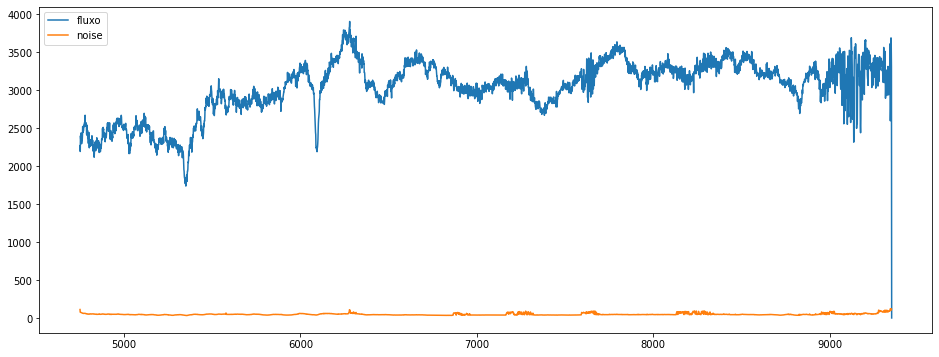

In [9]:
plt.figure(figsize=(16,6))
plt.plot(wave, gal_lin, label="fluxo")
plt.plot(wave, noise, label="noise")

plt.legend()

In [10]:
mask = wave < 6200

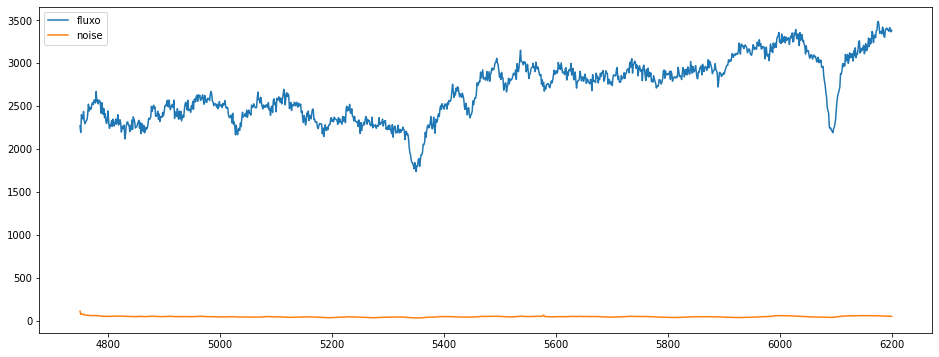

In [11]:
plt.figure(figsize=(16,6))
plt.plot(wave[mask], gal_lin[mask], label="fluxo")
plt.plot(wave[mask], noise[mask], label="noise")

plt.legend()

In [12]:
gal_lin = gal_lin[mask] #novo fluxo mascarado (até 6200A)
wave    = wave[mask]    #novo comprimento de onda mascarado (até 6200A)
noise   = noise[mask]   #novo noise mascarado (até 6200A)

In [13]:
lamRange1 = h1['CRVAL1'] + np.array([0., h1['CDELT1']*(len(gal_lin) - 1)]) #soma do primeiro comp. de onda com o que falta para chegar no último.
print(lamRange1)

[4750.17382812 6198.92382812]


In [14]:
galaxy_rebin, logLam1, velscale = util.log_rebin(lamRange1, gal_lin) 
galaxy = galaxy_rebin/np.median(galaxy_rebin)  # Normalize o espectro para evitar problemas numéricos

noise = noise/np.median(galaxy_rebin)

In [15]:
vazdekis = glob.glob(ppxf_dir + '/miles_models/Mun1.30*.fits') #glob.glob lista todos arquivos do template
FWHM_tem = 2.51  # Vazdekis+10 spectra have a constant resolution FWHM of 2.51A.
velscale_ratio = 2  # adopts 2x higher spectral sampling for templates than for galaxy

In [16]:
hdu = fits.open(vazdekis[0])
ssp = hdu[0].data     # Speech Signal Processing module
h2 = hdu[0].header
lamRange2 = h2['CRVAL1'] + np.array([0., h2['CDELT1']*(h2['NAXIS1'] - 1)]) 
sspNew, logLam2, velscale_temp = util.log_rebin(lamRange2, ssp, velscale=velscale/velscale_ratio)
templates = np.empty((sspNew.size, len(vazdekis)))

In [17]:
print (lamRange2) #comprimento de onda dos templates. 

[3540.5 7409.6]


In [18]:
# Convolve the whole Vazdekis library of spectral templates
# with the quadratic difference between the SAURON and the
# Vazdekis instrumental resolution. Logarithmically rebin
# and store each template as a column in the array TEMPLATES.

# Quadratic sigma difference in pixels Vazdekis --> SAURON
# The formula below is rigorously valid if the shapes of the
# instrumental spectral profiles are well approximated by Gaussians.
    
FWHM_dif = np.sqrt(FWHM_gal**2 - FWHM_tem**2) #piorando templates para ficar parecido com galaxias.
sigma = FWHM_dif/2.355/h2['CDELT1']  # Sigma difference in pixels

for j, file in enumerate(vazdekis): #j = 149
    hdu = fits.open(file)
    ssp = hdu[0].data
    ssp = ndimage.gaussian_filter1d(ssp, sigma) #degrada template # axis = -1, cval = 0.0, truncate = 4.0
    sspNew, logLam2, velscale_temp = util.log_rebin(lamRange2, ssp, velscale=velscale/velscale_ratio) 
    templates[:, j] = sspNew/np.median(sspNew)  # Normalizes templates
    
# The galaxy and the template spectra do not have the same starting wavelength.
# For this reason an extra velocity shift DV has to be applied to the template
# to fit the galaxy spectrum. We remove this artificial shift by using the
# keyword VSYST in the call to PPXF below, so that all velocities are
# measured with respect to DV. This assume the redshift is negligible.
# In the case of a high-redshift galaxy one should de-redshift its
# wavelength to the rest frame before using the line below (see above).

c = 299792.458  #Speed of light in km/s
dv = (np.mean(logLam2[:velscale_ratio]) - logLam1[0])*c  # km/s  # dv = -92777.66322243382

z = 0.035  # Initial redshift estimate of the galaxy
goodPixels = util.determine_goodpixels(logLam1, lamRange2, z)

# Here the actual fit starts. The best fit is plotted on the screen.
# Gas emission lines are excluded from the pPXF fit using the GOODPIXELS keyword.

vel = c*np.log(1 + z)   # eq.(8) of Cappellari (2017) #vel = 449.3517573723122
start = [vel, 200.]  # (km/s), starting guess for [V, sigma] --> com estimativa inicial p/ parâmetros LOSVD
t = clock() #t = 2220.969080546

# Degrees respectivamente 4, 6, 10 e 12

 Best Fit:       Vel     sigma
 comp.  0:      9979       436
chi2/DOF: 1.474; degree = 4; mdegree = 0
method = capfit; Jac calls: 5; Func calls: 17; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%):  2 / 150


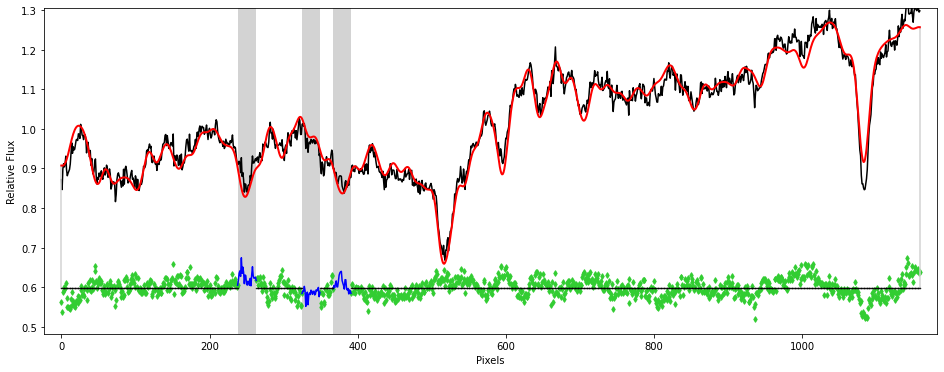

In [28]:
plt.figure(figsize=(16,6))
pp = ppxf(templates, galaxy, noise, velscale, start,
              goodpixels=goodPixels, plot=True, moments=2,
              degree=4, vsyst=dv, velscale_ratio=velscale_ratio) #vsyst --> vel. sistemática da expansão do universo
#chi2 = ideia de quão bom o ajuste está / DOF = grau liberdade  #degree --> melhora ajuste 

 Best Fit:       Vel     sigma        h3        h4
 comp.  0:      9991       431     0.004     0.049
chi2/DOF: 1.159; degree = 8; mdegree = 0
method = capfit; Jac calls: 7; Func calls: 37; Status: 4
linear_method = lsq_box; Nonzero Templates (>0.1%):  1 / 150


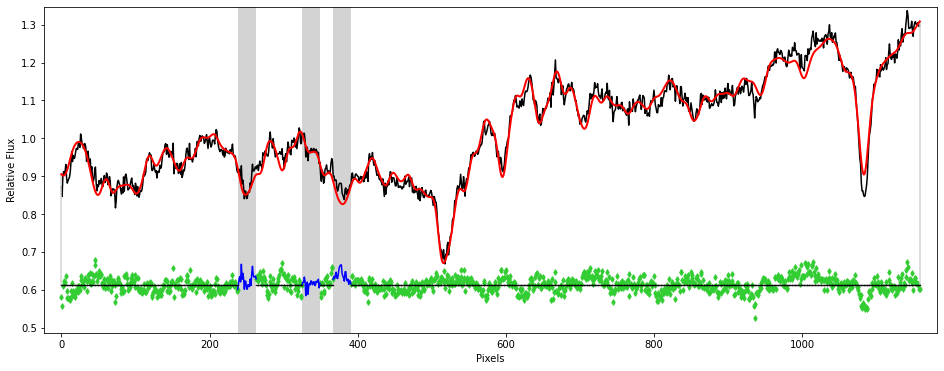

In [30]:
plt.figure(figsize=(16,6))
pp = ppxf(templates, galaxy, noise, velscale, start,
              goodpixels=goodPixels, plot=True, moments=4,
              degree=8, vsyst=dv, velscale_ratio=velscale_ratio) #vsyst --> vel. sistemática da expansão do universo
#chi2 = ideia de quão bom o ajuste está / DOF = grau liberdade  #degree --> melhora ajuste 

 Best Fit:       Vel     sigma        h3        h4
 comp.  0:      9981       429    -0.012     0.044
chi2/DOF: 1.364; degree = 6; mdegree = 0
method = capfit; Jac calls: 7; Func calls: 37; Status: 4
linear_method = lsq_box; Nonzero Templates (>0.1%):  2 / 150


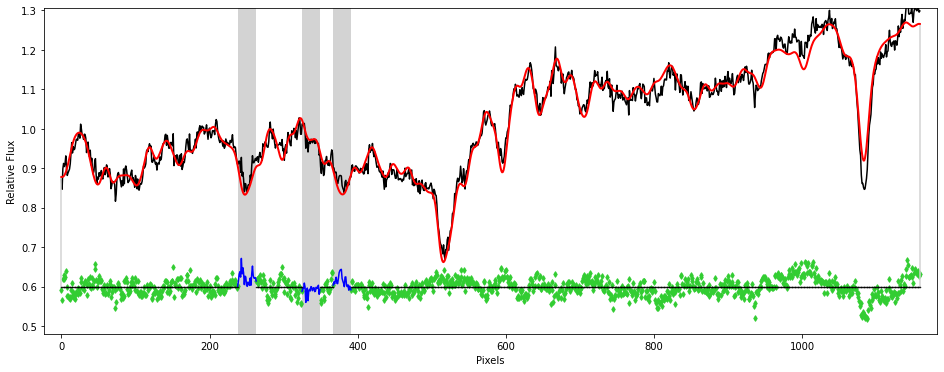

In [25]:
plt.figure(figsize=(16,6))
pp = ppxf(templates, galaxy, noise, velscale, start,
              goodpixels=goodPixels, plot=True, moments=4,
              degree=6, vsyst=dv, velscale_ratio=velscale_ratio) #vsyst --> vel. sistemática da expansão do universo
#chi2 = ideia de quão bom o ajuste está / DOF = grau liberdade  #degree --> melhora ajuste 

 Best Fit:       Vel     sigma        h3        h4
 comp.  0:      9985       406    -0.007     0.015
chi2/DOF: 1.034; degree = 10; mdegree = 0
method = capfit; Jac calls: 7; Func calls: 37; Status: 4
linear_method = lsq_box; Nonzero Templates (>0.1%):  2 / 150


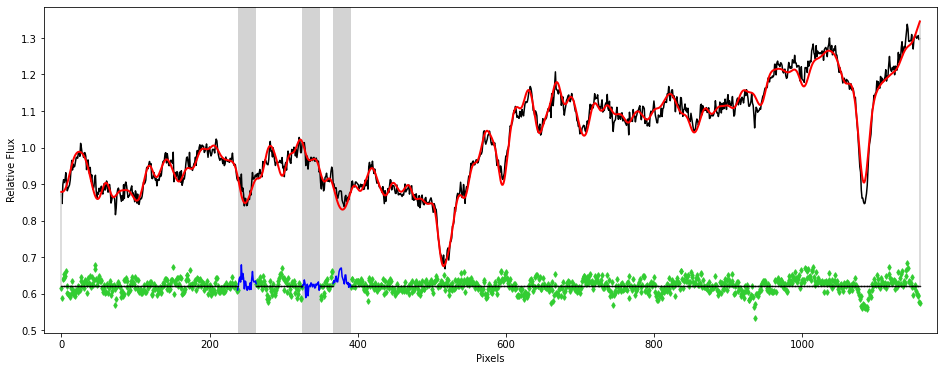

In [31]:
plt.figure(figsize=(16,6))
pp = ppxf(templates, galaxy, noise, velscale, start,
              goodpixels=goodPixels, plot=True, moments=4,
              degree=10, vsyst=dv, velscale_ratio=velscale_ratio) #vsyst --> vel. sistemática da expansão do universo
#chi2 = ideia de quão bom o ajuste está / DOF = grau liberdade  #degree --> melhora ajuste 

 Best Fit:       Vel     sigma        h3        h4
 comp.  0:      9983       404    -0.011     0.014
chi2/DOF: 1.023; degree = 12; mdegree = 0
method = capfit; Jac calls: 7; Func calls: 37; Status: 4
linear_method = lsq_box; Nonzero Templates (>0.1%):  2 / 150


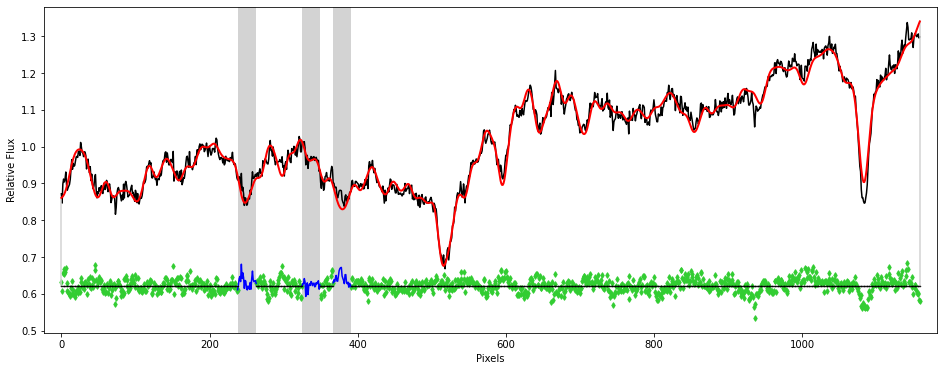

In [32]:
plt.figure(figsize=(16,6))
pp = ppxf(templates, galaxy, noise, velscale, start,
              goodpixels=goodPixels, plot=True, moments=4,
              degree=12, vsyst=dv, velscale_ratio=velscale_ratio) #vsyst --> vel. sistemática da expansão do universo
#chi2 = ideia de quão bom o ajuste está / DOF = grau liberdade  #degree --> melhora ajuste 